<a href="https://colab.research.google.com/github/haruka20010217/SSD-Tensorflow/blob/master/SSD_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow==1.0.0
import tensorflow as tf
print(tf.__version__)

     |████████████████████████████████| 44.5MB 95kB/s 
  Found existing installation: tensorflow 2.3.0
    Uninstalling tensorflow-2.3.0:
      Successfully uninstalled tensorflow-2.3.0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:472: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:473: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:474: FutureWarning: Passing (type, 1) or 

1.0.0


In [ ]:
!git clone https://github.com/balancap/SSD-Tensorflow.git

Cloning into 'SSD-Tensorflow'...
remote: Enumerating objects: 809, done.
remote: Total 809 (delta 0), reused 0 (delta 0), pack-reused 809
Receiving objects: 100% (809/809), 113.09 MiB | 10.11 MiB/s, done.
Resolving deltas: 100% (545/545), done.


In [ ]:
import os
import math
import random

import numpy as np
import tensorflow as tf
import cv2

slim = tf.contrib.slim

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
import sys
sys.path.append('../')

In [ ]:
%cd "/content/SSD-Tensorflow/notebooks"

/content/SSD-Tensorflow/notebooks


In [ ]:
from nets import ssd_vgg_300, ssd_common, np_methods
from preprocessing import ssd_vgg_preprocessing
from notebooks import visualization

In [ ]:
# TensorFlow session: grow memory when needed. TF, DO NOT USE ALL MY GPU MEMORY!!!
gpu_options = tf.GPUOptions(allow_growth=True)
config = tf.ConfigProto(log_device_placement=False, gpu_options=gpu_options)
isess = tf.InteractiveSession(config=config)

In [ ]:
# Input placeholder.
net_shape = (300, 300)
data_format = 'NHWC'
img_input = tf.placeholder(tf.uint8, shape=(None, None, 3))
# Evaluation pre-processing: resize to SSD net shape.
image_pre, labels_pre, bboxes_pre, bbox_img = ssd_vgg_preprocessing.preprocess_for_eval(
    img_input, None, None, net_shape, data_format, resize=ssd_vgg_preprocessing.Resize.WARP_RESIZE)
image_4d = tf.expand_dims(image_pre, 0)

# Define the SSD model.
reuse = True if 'ssd_net' in locals() else None
ssd_net = ssd_vgg_300.SSDNet()
with slim.arg_scope(ssd_net.arg_scope(data_format=data_format)):
    predictions, localisations, _, _ = ssd_net.net(image_4d, is_training=False, reuse=reuse)


# SSD default anchor boxes.
ssd_anchors = ssd_net.anchors(net_shape)

In [ ]:
# Main image processing routine.
def process_image(img, select_threshold=0.5, nms_threshold=.45, net_shape=(300, 300)):
    # Run SSD network.
    rimg, rpredictions, rlocalisations, rbbox_img = isess.run([image_4d, predictions, localisations, bbox_img],
                                                              feed_dict={img_input: img})
    
    # Get classes and bboxes from the net outputs.
    rclasses, rscores, rbboxes = np_methods.ssd_bboxes_select(
            rpredictions, rlocalisations, ssd_anchors,
            select_threshold=select_threshold, img_shape=net_shape, num_classes=21, decode=True)
    
    rbboxes = np_methods.bboxes_clip(rbbox_img, rbboxes)
    rclasses, rscores, rbboxes = np_methods.bboxes_sort(rclasses, rscores, rbboxes, top_k=400)
    rclasses, rscores, rbboxes = np_methods.bboxes_nms(rclasses, rscores, rbboxes, nms_threshold=nms_threshold)
    # Resize bboxes to original image shape. Note: useless for Resize.WARP!
    rbboxes = np_methods.bboxes_resize(rbbox_img, rbboxes)
    return rclasses, rscores, rbboxes

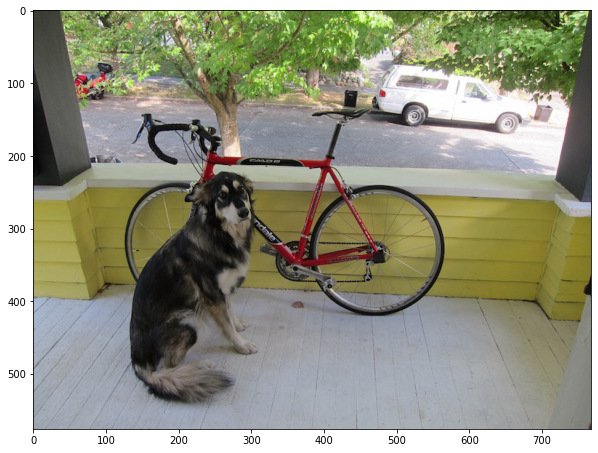

In [ ]:
# Test on some demo image and visualize output.
path = '../demo/'
image_names = sorted(os.listdir(path))

img = mpimg.imread(path + image_names[-5])
rclasses, rscores, rbboxes =  process_image(img)

# visualization.bboxes_draw_on_img(img, rclasses, rscores, rbboxes, visualization.colors_plasma)
visualization.plt_bboxes(img, rclasses, rscores, rbboxes)